In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-satisfaction/sample_submission.csv
/kaggle/input/santander-customer-satisfaction/train.csv
/kaggle/input/santander-customer-satisfaction/test.csv


In [7]:
# 数据处理
import numpy as np
import pandas as pd
import random
import itertools
from scipy import stats
from scipy.sparse import hstack

# 数据可视化
import matplotlib.pyplot as plt
# 在导入matplotlib后添加字体设置

import seaborn as sns
import matplotlib.font_manager as fm

# 特征工程
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# 模型
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score, log_loss

# 杂质
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
sns.set(palette='muted', style='whitegrid')
np.random.seed(13154)

In [8]:
train = pd.read_csv('/kaggle/input/santander-customer-satisfaction/train.csv')
test = pd.read_csv('/kaggle/input/santander-customer-satisfaction/test.csv')

print("训练集样本数为 %i，变量数为 %i" % (train.shape[0], train.shape[1]))
print("测试集样本数为 %i，变量数为 %i" % (test.shape[0], test.shape[1]))

训练集样本数为 76020，变量数为 371
测试集样本数为 75818，变量数为 370


In [9]:
train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [10]:
test.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.10
1,5,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.72
2,6,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.95
3,7,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.61
4,9,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.73


In [11]:
import os

# 创建output目录（如果不存在）
os.makedirs('./output', exist_ok=True)

# 现在可以安全保存
train.describe().round(3).T.to_csv('./output/train_describe.csv')

In [12]:
# 过滤零方差特征
i = 0
for col in train.columns:
    if train[col].var() == 0:
        i += 1
        del train[col]
        del test[col]
print("%i 个特征具有零方差并且已被删除" % (i))

34 个特征具有零方差并且已被删除


In [13]:
# 过滤稀疏特征
i = 0

for col in train.columns:
    if np.percentile(train[col], 99) == 0:
        i += 1
        del train[col]
        del test[col]

print("%i 个特征是稀疏的并且已被删除" % (i))

188 个特征是稀疏的并且已被删除


In [14]:
combinations = list(itertools.combinations(train.columns, 2))
print(combinations[:20])
len(combinations)

[('ID', 'var3'), ('ID', 'var15'), ('ID', 'imp_ent_var16_ult1'), ('ID', 'imp_op_var39_comer_ult1'), ('ID', 'imp_op_var39_comer_ult3'), ('ID', 'imp_op_var41_comer_ult1'), ('ID', 'imp_op_var41_comer_ult3'), ('ID', 'imp_op_var41_efect_ult1'), ('ID', 'imp_op_var41_efect_ult3'), ('ID', 'imp_op_var41_ult1'), ('ID', 'imp_op_var39_efect_ult1'), ('ID', 'imp_op_var39_efect_ult3'), ('ID', 'imp_op_var39_ult1'), ('ID', 'ind_var1_0'), ('ID', 'ind_var5_0'), ('ID', 'ind_var5'), ('ID', 'ind_var8_0'), ('ID', 'ind_var8'), ('ID', 'ind_var12_0'), ('ID', 'ind_var12')]


11026

In [15]:
# 删除重复特征，保留其一
import itertools

combinations = list(itertools.combinations(train.columns, 2))
remove = []
keep = []

for f1, f2 in combinations:
    if (f1 not in remove) & (f2 not in remove):
        if train[f1].equals(train[f2]):
            remove.append(f1)
            keep.append(f2)

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)
print("%i 个特征是重复的，并且 %i 个特征已被删除" % (len(remove)*2, len(remove)))
print("其中特征 %s 被删除\n特征 %s 被保留下来" % (remove, keep))

del remove
del keep
del combinations

12 个特征是重复的，并且 6 个特征已被删除
其中特征 ['ind_var26_0', 'ind_var25_0', 'ind_var37_0', 'num_var26_0', 'num_var25_0', 'num_var37_0'] 被删除
特征 ['ind_var26', 'ind_var25', 'ind_var37', 'num_var26', 'num_var25', 'num_var37'] 被保留下来


In [16]:
train.shape, test.shape

((76020, 143), (75818, 142))

In [17]:
train.isnull().sum().sum()

0

In [18]:
test.isnull().sum().sum()

0

In [19]:
# 定义绘图函数countplot_target
def countplot_target(df, h=500):
    """
    绘制目标变量的频率分布，并输出满意客户和不满意客户的数量
    h: 数据标签的附加高度
    """
    plt.figure(figsize=(5, 5))
    plt.rcParams["font.sans-serif"] = ["SimHei"]
    plt.rcParams["axes.unicode_minus"] = False
    ax = sns.countplot(x='TARGET', data=df)
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + h,
                '{:1.2f}%'.format(height*100/df.shape[0]), ha="center")
    
    plt.title("TARGET 变量的频率分布图")
    print("满意客户的数量为 %i，不满意客户的数量为 %i" %
          (df[df['TARGET'] == 0].shape[0], df[df['TARGET'] == 1].shape[0]))
    plt.show()

In [20]:
# 定义绘图函数histplot_comb
def histplot_comb(col, train=train, test=test, size=(20, 5), bins=20):
    """  
绘制训练集和测试集某特征的直方图  
    """  
    plt.subplots(1, 2, figsize=size)  
    
    # 训练集直方图
    plt.subplot(121)  
    plt.title("训练集特征 {} 值的分布".format(col))  
    plt.ylabel('频数')  
    plt.xlabel(col)  
    plt.hist(train[col], bins=bins, alpha=0.7, color='blue', edgecolor='black')
    
    # 测试集直方图  
    plt.subplot(122)  
    plt.title("测试集特征 {} 值的分布".format(col))  
    plt.ylabel('频数')
    plt.xlabel(col)
    plt.hist(test[col], bins=bins, alpha=0.7, color='red', edgecolor='black')
    
    plt.tight_layout()
    plt.show()

In [21]:
# 定义绘图函数valuecounts_plot
def valuecounts_plot(col, train=train, test=test):
    """  
    绘制训练集和测试集特定列的频数分布折线图，并输出出现百分比最高的前 5 个值和最低的前 5 个值
    """  
    # 检查列是否存在
    if col not in train.columns:
        print(f"错误：训练集中不存在列 '{col}'")
        return
    if col not in test.columns:
        print(f"警告：测试集中不存在列 '{col}'")
    
    # 创建图形
    plt.subplots(1, 2, figsize=(15, 6))
    
    # 训练集频数分布
    plt.subplot(121)
    df_train = train[col].value_counts().sort_index()
    sns.lineplot(x=df_train.index, y=df_train.values)
    plt.title("{} 的频数分布折线图（训练集）".format(col))
    plt.xlabel(col)
    plt.ylabel('频数')
    
    # 测试集频数分布
    plt.subplot(122)
    df_test = test[col].value_counts().sort_index()
    sns.lineplot(x=df_test.index, y=df_test.values)
    plt.title("{} 的频数分布折线图（测试集）".format(col))
    plt.xlabel(col)
    plt.ylabel('频数')
    
    plt.tight_layout()
    plt.show()
    
    # 输出统计分析
    print("*" * 100)
    print("训练集特征 '%s' 其值占比（top 5）：" % (col))
    print("值\t占比%")
    print((train[col].value_counts() * 100 / train.shape[0]).iloc[:5])
    
    print("*" * 100)
    print("训练集特征 '%s' 其值占比（bottom 5）：" % (col))
    print("值\t占比%")
    print((train[col].value_counts() * 100 / train.shape[0]).iloc[-5:])
    
    print("*" * 100)
    print("测试集特征 '%s' 其值占比（top 5）：" % (col))
    print("值\t占比%")
    print((test[col].value_counts() * 100 / test.shape[0]).iloc[:5])
    
    print("*" * 100)
    print("测试集特征 '%s' 其值占比（bottom 5）：" % (col))
    print("值\t占比%")
    print((test[col].value_counts() * 100 / test.shape[0]).iloc[-5:])

In [22]:
# 定义绘图函数histplot_target
def histplot_target(col, df=train, height=6, bins=20):
    """
    绘制数据集特征列在不同目标变量值下的频数分布图
    """
    sns.FacetGrid(data=df, hue='TARGET', height=height).map(plt.hist, col, bins=bins).add_legend()
    plt.title("特征%s在不同目标变量值下的频数分布" % (col))
    plt.ylabel("频数")
    plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

满意客户的数量为 73012，不满意客户的数量为 3008


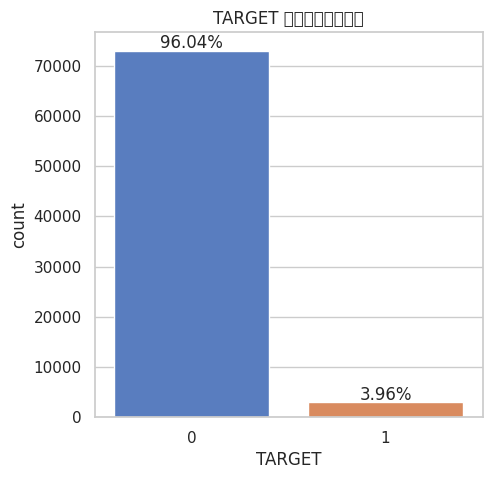

In [23]:
# 调用函数分析训练集的TARGET分布
countplot_target(train)

In [24]:
##查看VAR3这个特征
np.array(sorted(train['var3'].unique()))

array([-999999,       0,       1,       2,       3,       4,       5,
             6,       7,       8,       9,      10,      11,      12,
            13,      14,      15,      16,      17,      18,      19,
            20,      21,      22,      23,      24,      25,      26,
            27,      28,      29,      30,      31,      32,      33,
            34,      35,      36,      38,      40,      41,      42,
            43,      44,      45,      46,      47,      48,      49,
            50,      51,      52,      53,      54,      55,      56,
            57,      58,      59,      60,      61,      62,      63,
            64,      65,      66,      68,      69,      71,      72,
            73,      74,      76,      77,      78,      79,      81,
            82,      84,      85,      86,      87,      88,      89,
            90,      91,      93,      94,      95,      96,      97,
            98,      99,     100,     101,     102,     103,     104,
           105,     

In [25]:
print("var3唯一值的数量为: %i" % (len(np.array(sorted(train['var3'].unique())))))

var3唯一值的数量为: 208


In [26]:
print("值\t计数")
print(train['var3'].value_counts()[:5])
print("\n值\t占比%")
print(train['var3'].value_counts()[:5] / train.shape[0] * 100)

值	计数
var3
 2         74165
 8           138
-999999      116
 9           110
 3           108
Name: count, dtype: int64

值	占比%
var3
 2         97.559853
 8          0.181531
-999999     0.152591
 9          0.144699
 3          0.142068
Name: count, dtype: float64


In [27]:
print("值\t计数")
print(test['var3'].value_counts()[:5])
print("\n值\t占比%")
print(test['var3'].value_counts()[:5] / test.shape[0] * 100)

值	计数
var3
 2         73962
-999999      120
 8           116
 9           108
 13          107
Name: count, dtype: int64

值	占比%
var3
 2         97.552032
-999999     0.158274
 8          0.152998
 9          0.142446
 13         0.141127
Name: count, dtype: float64


2的比例高，所以用2来替换掉缺失值

In [28]:
train['var3'].replace(-999999, 2, inplace=True)
test['var3'].replace(-999999, 2, inplace=True)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

满意客户的数量为 71328，不满意客户的数量为 2953


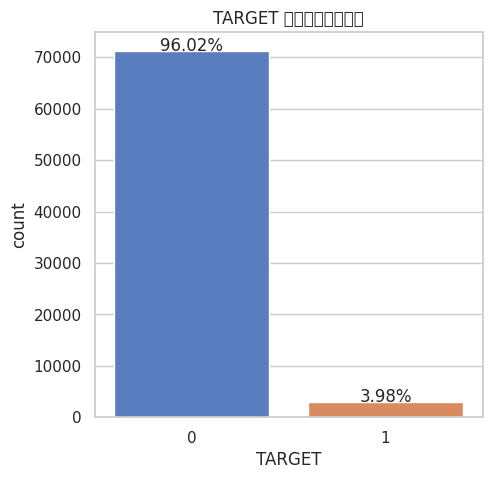

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


满意客户的数量为 1684，不满意客户的数量为 55


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

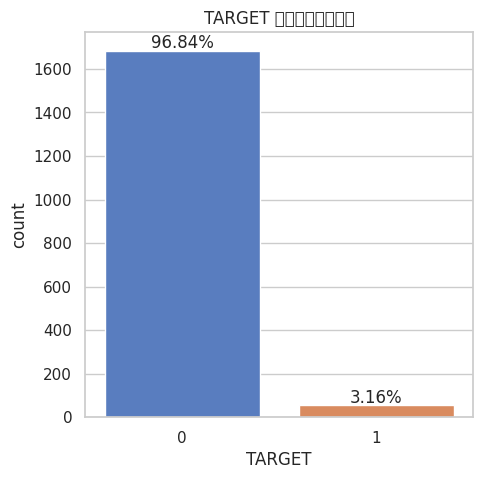

In [29]:
countplot_target(train[train['var3'] == 2], h=20)
countplot_target(train[train['var3'] != 2], h=10)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

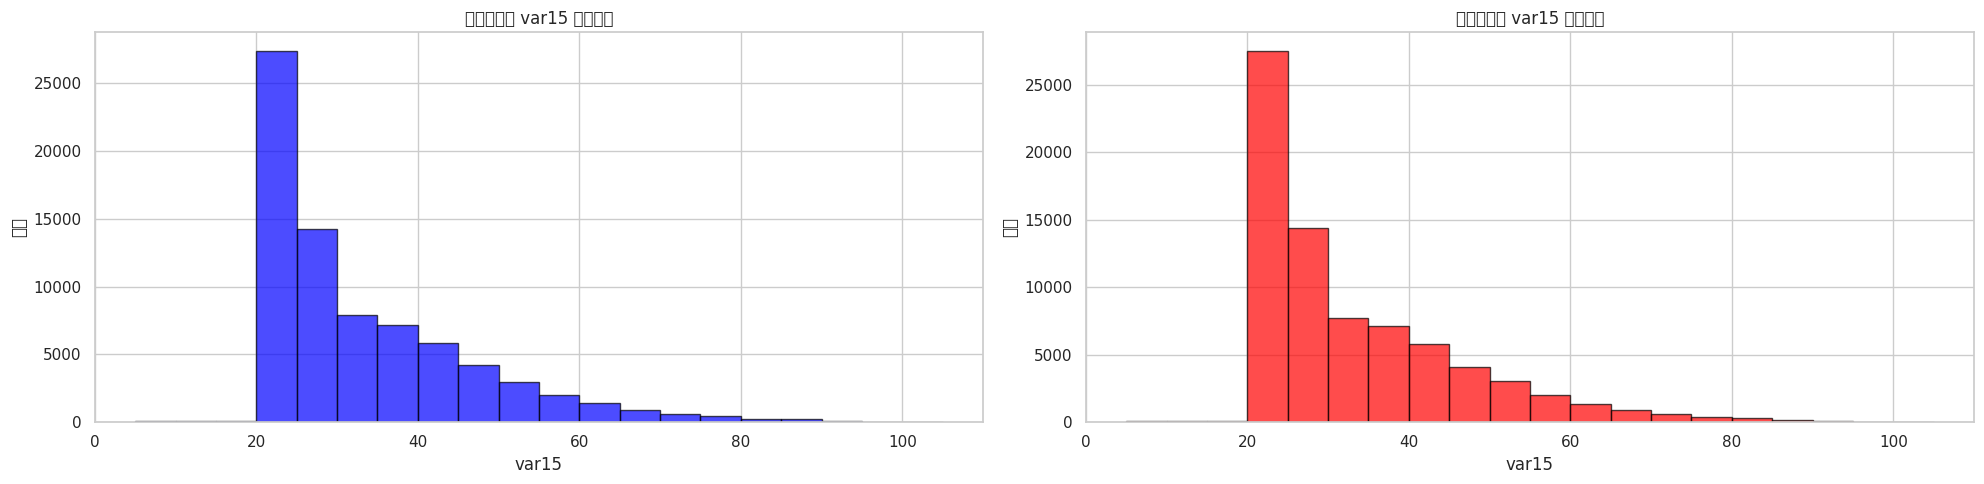

训练集中年龄在30岁以下的客户约占所有数据的 56.15%
测试集中年龄在30岁以下的客户约占所有数据的 56.58%


In [30]:
histplot_comb('var15')
print("训练集中年龄在30岁以下的客户约占所有数据的 %.2f%%" % (stats.percentileofscore(train['var15'].values, 30)))
print("测试集中年龄在30岁以下的客户约占所有数据的 %.2f%%" % (stats.percentileofscore(test['var15'].values, 30)))

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

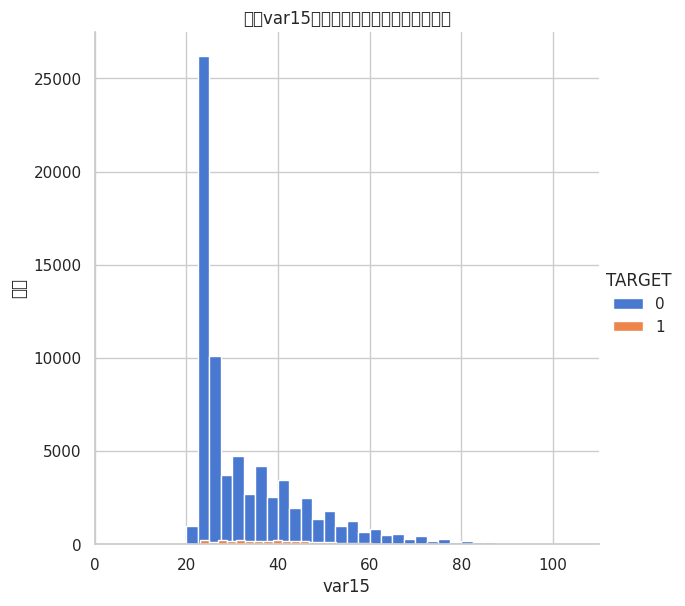

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

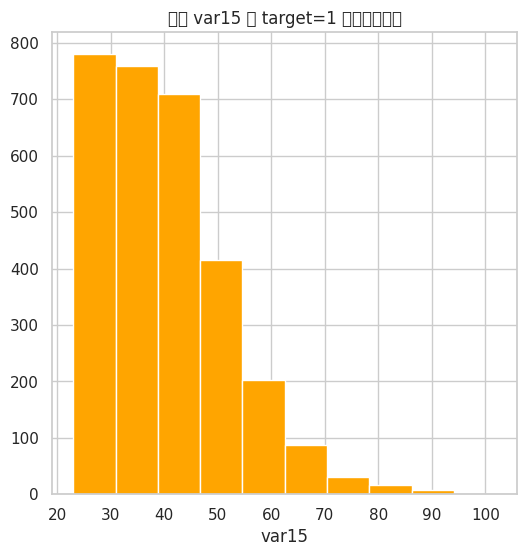

不满意客户的var15最小值为：23，不满意客户的var15最大值为：102


In [31]:
ax = histplot_target('var15', bins=40)

plt.figure(figsize=(6, 6))
mask = train[train['TARGET'] == 1]
plt.hist(mask['var15'], color='orange')
plt.title("特征 var15 在 target=1 下的频数分布")
plt.xlabel('var15')
plt.show()

print("不满意客户的var15最小值为：%i，不满意客户的var15最大值为：%i" % (mask['var15'].min(), mask['var15'].max()))

In [32]:
# 由前面已经知道23是个分水岭，创建新特征用来判断客户是否小于23岁.是1否0
for df in [train, test]:
    df['var15_below_23'] = np.zeros(df.shape[0], dtype=int)
    df.loc[df['var15'] < 23, 'var15_below_23'] = 1

In [33]:
#再试试看23是不是真的分水岭，等距分箱为5段分箱后会离散化更容易二分类
_, bins = pd.cut(train['var15'].values, 5, retbins=True)
print(_)

[(4.9, 25.0], (25.0, 45.0], (4.9, 25.0], (25.0, 45.0], (25.0, 45.0], ..., (45.0, 65.0], (25.0, 45.0], (4.9, 25.0], (4.9, 25.0], (45.0, 65.0]]
Length: 76020
Categories (5, interval[float64, right]): [(4.9, 25.0] < (25.0, 45.0] < (45.0, 65.0] < (65.0, 85.0] < (85.0, 105.0]]


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

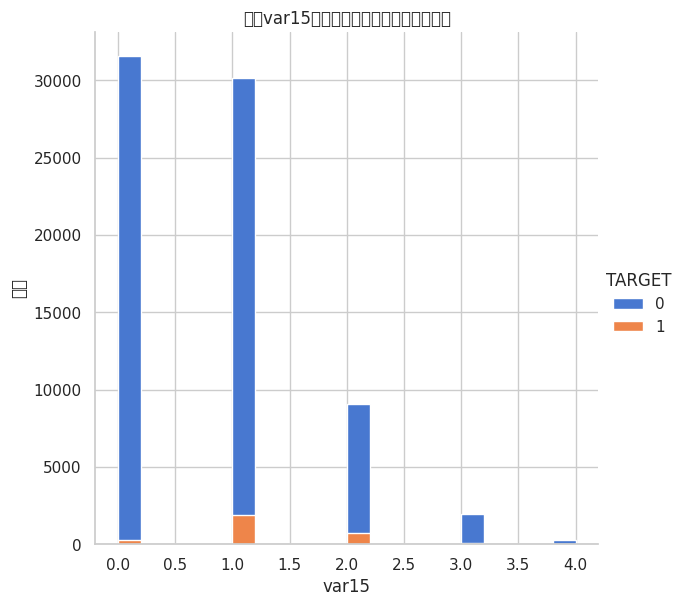

In [34]:
train['var15'] = pd.cut(train['var15'].values, bins, labels=False)
test['var15'] = pd.cut(test['var15'].values, bins, labels=False)
histplot_target('var15')

In [35]:
print("var38 最小值为: %.3f, 最大值为: %.3f" % (train['var38'].min(), train['var38'].max()))

var38 最小值为: 5163.750, 最大值为: 22034738.760


In [36]:
train['var38'].value_counts()

var38
117310.979016    14868
451931.220000       16
463625.160000       12
288997.440000       11
104563.800000       11
                 ...  
45876.570000         1
151505.640000        1
74548.170000         1
339493.920000        1
71010.540000         1
Name: count, Length: 57736, dtype: int64

In [37]:
for i in np.arange(0, 1.1, 0.1):
    print("%i percentile: %i" % (i*100, np.quantile(train['var38'].values, i)))

0 percentile: 5163
10 percentile: 48070
20 percentile: 61496
30 percentile: 74152
40 percentile: 88571
50 percentile: 106409
60 percentile: 117310
70 percentile: 117310
80 percentile: 132859
90 percentile: 182585
100 percentile: 22034738


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

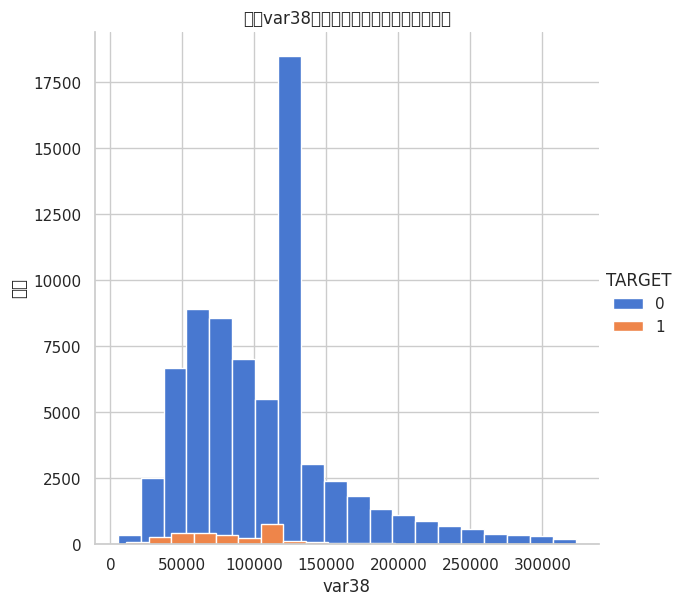

In [38]:
mask = train[train['var38'] <= np.quantile(train['var38'].values, 0.975)]
histplot_target('var38', df=mask, bins=20)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

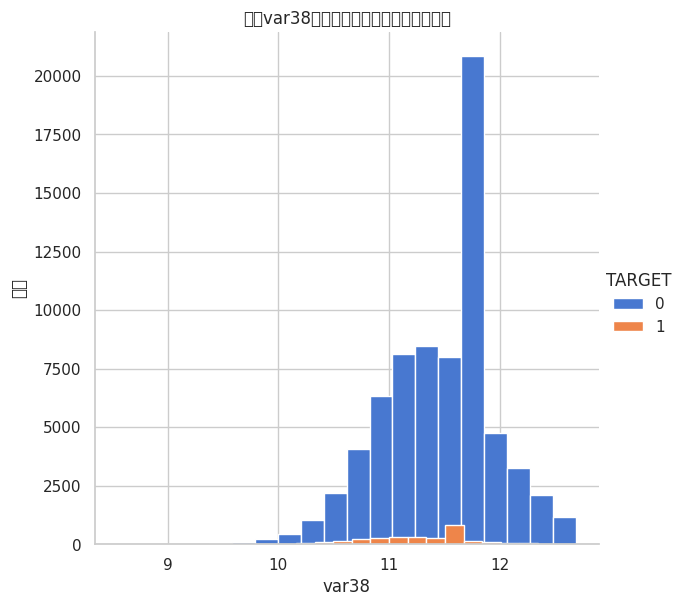

In [39]:
mask['var38'] = np.log(mask['var38'].values)
histplot_target('var38', df=mask, bins=20)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

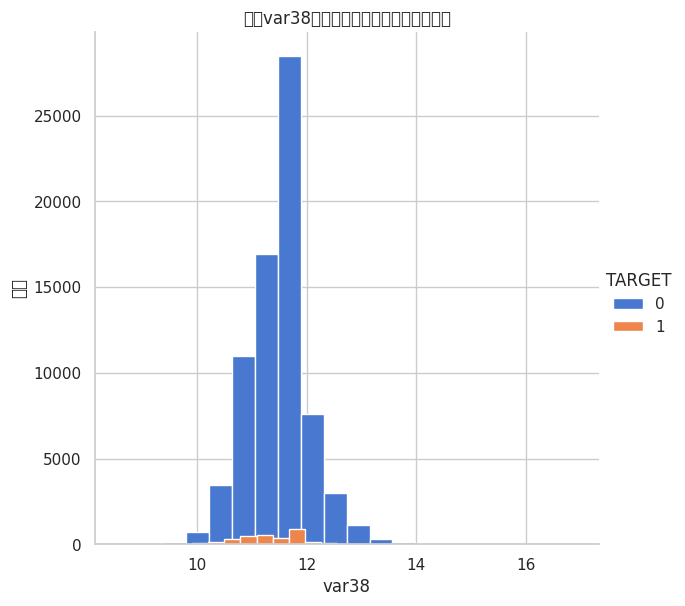

In [40]:
for df in [train, test]:
    df['var38'] = np.log(df['var38'].values)
histplot_target('var38', bins=20)

观测其他变量

关键词前缀

In [41]:
import re
[col for col in train.columns if col[:3] == 'var']

['var3', 'var15', 'var36', 'var21', 'var38', 'var15_below_23']

In [42]:
f_keywords = {col.split('_')[0] for col in train.columns if (len(col.split('_')) > 1) & ('var15' not in col)}
f_keywords

{'imp', 'ind', 'num', 'saldo'}

In [43]:
# 计算每种关键词前缀特征的数量
f_keywords = dict(zip(f_keywords, np.zeros(len(f_keywords), dtype=int)))
for key in f_keywords.keys():
    for col in train.columns:
        if key in col:
            f_keywords[key] += 1
f_keywords

{'ind': 32, 'imp': 14, 'saldo': 26, 'num': 64}

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

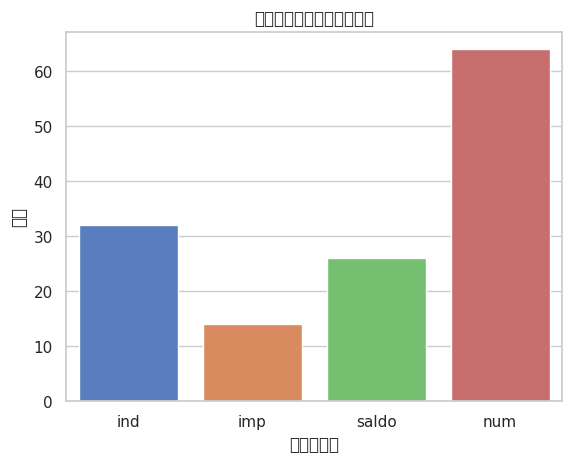

In [44]:
# 将统计结果转换为 pandas Series
k = pd.Series(f_keywords)

# 使用 seaborn 绘制条形图
ax = sns.barplot(x=k.index, y=k.values)

# 设置图表标题和坐标轴标签
plt.title("特征关键词前缀的频数分布")
plt.ylabel('频数')
plt.xlabel('关键词前缀')  # 修正：删除了多余的右括号

# 显示图表
plt.show()

In [45]:
imp = [col for col in train.columns if 'imp' in col]
print('关键词前缀imp特征共有 %d 个' % (len(imp)))
imp

关键词前缀imp特征共有 14 个


['imp_ent_var16_ult1',
 'imp_op_var39_comer_ult1',
 'imp_op_var39_comer_ult3',
 'imp_op_var41_comer_ult1',
 'imp_op_var41_comer_ult3',
 'imp_op_var41_efect_ult1',
 'imp_op_var41_efect_ult3',
 'imp_op_var41_ult1',
 'imp_op_var39_efect_ult1',
 'imp_op_var39_efect_ult3',
 'imp_op_var39_ult1',
 'imp_aport_var13_hace3',
 'imp_var43_emit_ult1',
 'imp_trans_var37_ult1']

In [46]:
import random
random.seed(a=0)
print('被随机选择中的imp特征：%s' % (random.sample(imp, 1)[0]))

被随机选择中的imp特征：imp_trans_var37_ult1


In [47]:
col = 'imp_trans_var37_ult1'
print('训练集中 %s 最小值为：%i，最大值为：%i' % (col, train[col].min(), train[col].max()))
print('测试集中 %s 最小值为：%i，最大值为：%i' % (col, test[col].min(), test[col].max()))

训练集中 imp_trans_var37_ult1 最小值为：0，最大值为：2310003
测试集中 imp_trans_var37_ult1 最小值为：0，最大值为：3000000


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

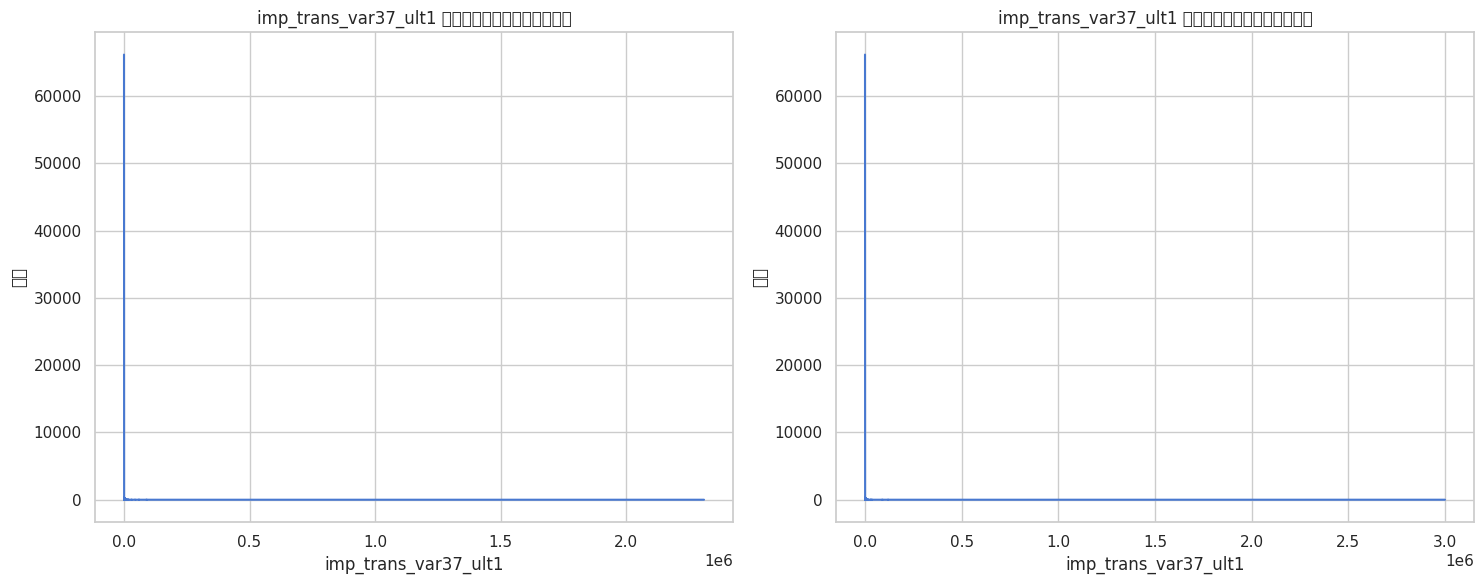

****************************************************************************************************
训练集特征 'imp_trans_var37_ult1' 其值占比（top 5）：
值	占比%
imp_trans_var37_ult1
0.0       87.069192
300.0      0.536701
600.0      0.420942
1500.0     0.361747
150.0      0.344646
Name: count, dtype: float64
****************************************************************************************************
训练集特征 'imp_trans_var37_ult1' 其值占比（bottom 5）：
值	占比%
imp_trans_var37_ult1
450.45      0.001315
21006.60    0.001315
2408.73     0.001315
382.89      0.001315
1434.99     0.001315
Name: count, dtype: float64
****************************************************************************************************
测试集特征 'imp_trans_var37_ult1' 其值占比（top 5）：
值	占比%
imp_trans_var37_ult1
0.0       87.235221
300.0      0.563191
600.0      0.465589
1500.0     0.391728
3000.0     0.319185
Name: count, dtype: float64
**************************************************************************************************

In [48]:
valuecounts_plot(train=train, test=test, col=col)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

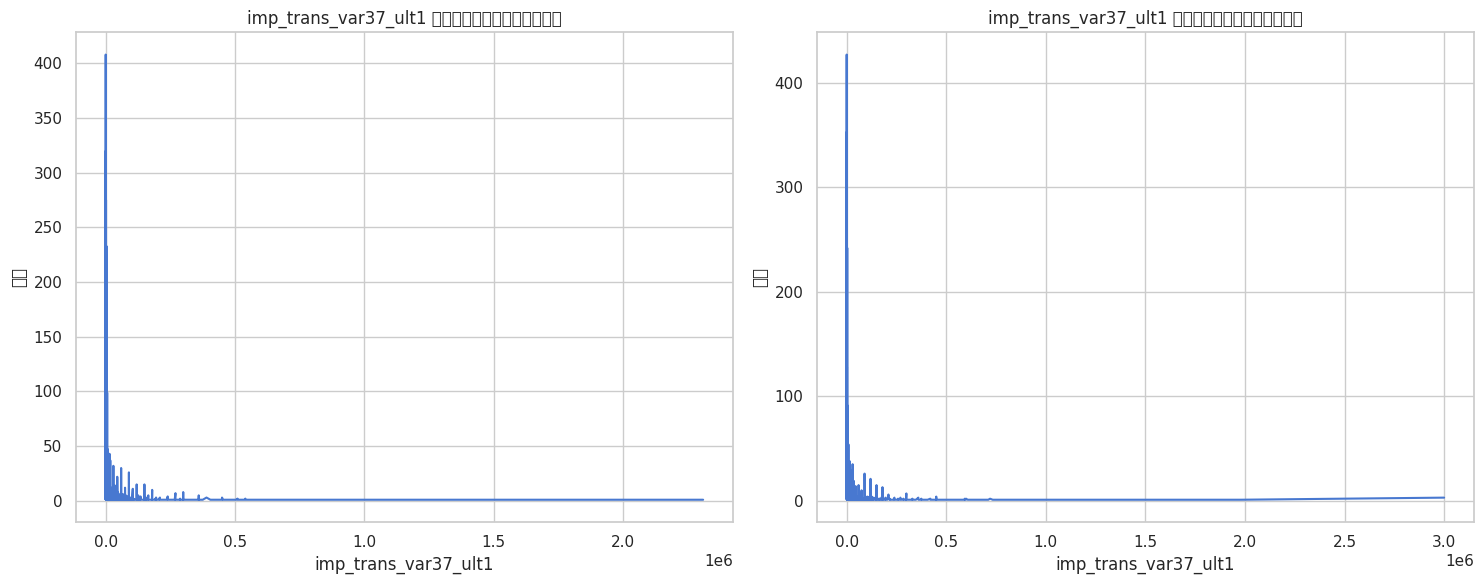

****************************************************************************************************
训练集特征 'imp_trans_var37_ult1' 其值占比（top 5）：
值	占比%
imp_trans_var37_ult1
300.0     4.150560
600.0     3.255341
1500.0    2.797558
150.0     2.665310
900.0     2.492370
Name: count, dtype: float64
****************************************************************************************************
训练集特征 'imp_trans_var37_ult1' 其值占比（bottom 5）：
值	占比%
imp_trans_var37_ult1
450.45      0.010173
21006.60    0.010173
2408.73     0.010173
382.89      0.010173
1434.99     0.010173
Name: count, dtype: float64
****************************************************************************************************
测试集特征 'imp_trans_var37_ult1' 其值占比（top 5）：
值	占比%
imp_trans_var37_ult1
300.0     4.412069
600.0     3.647448
1500.0    3.068816
3000.0    2.500517
900.0     2.448853
Name: count, dtype: float64
****************************************************************************************************
测试集特征 '

In [49]:
valuecounts_plot(train=train[train[col] != 0], test=test[test[col] != 0], col=col)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

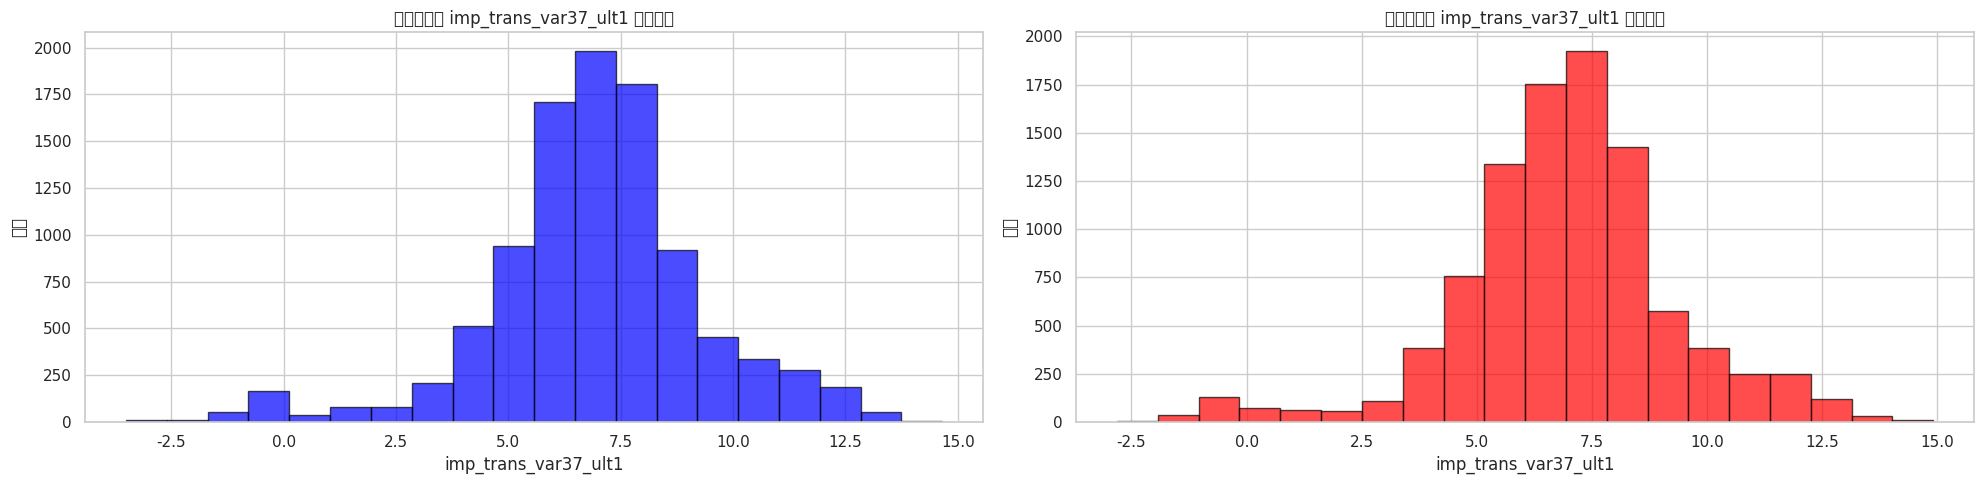

In [50]:
df = train[train[col] != 0]
df1 = test[test[col] != 0]
for data in [df, df1]:
    data.loc[data[col] != 0, col] = np.log(data.loc[data[col] != 0, col])

histplot_comb(col, train=df, test=df1)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

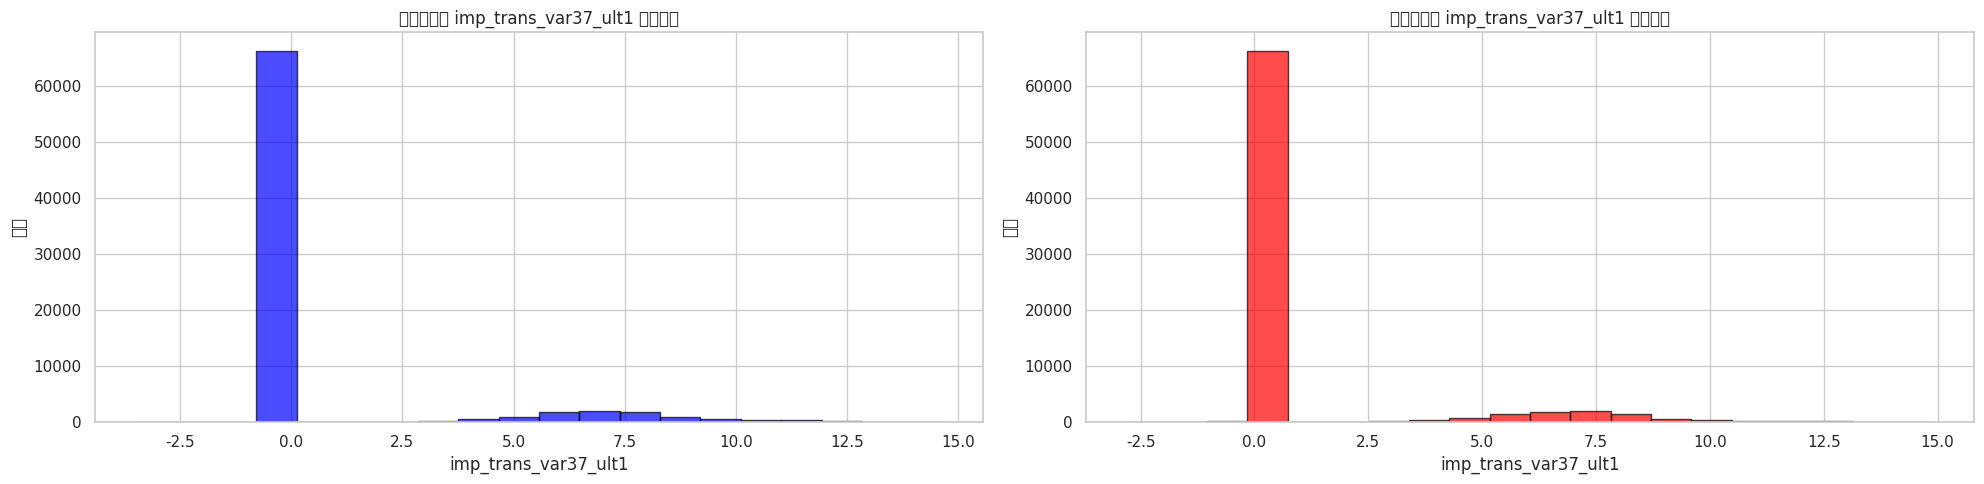

In [51]:
for df in [train, test]:
    df.loc[df[col] != 0, col] = np.log(df.loc[df[col] != 0, col])
histplot_comb(col, train=train, test=test)

In [52]:
import numpy as np

# 对所有imp特征进行处理
for col in imp:
    # 训练集
    train[col] = np.where(train[col] != 0, np.log(train[col]), train[col])
    # 测试集  
    test[col] = np.where(test[col] != 0, np.log(test[col]), test[col])

In [53]:
saldo = [col for col in train.columns if 'saldo' in col]
print("关键词前缀saldo特征共有 %i 个" % (len(saldo)))
saldo

关键词前缀saldo特征共有 26 个


['saldo_var5',
 'saldo_var8',
 'saldo_var12',
 'saldo_var13_corto',
 'saldo_var13',
 'saldo_var24',
 'saldo_var26',
 'saldo_var25',
 'saldo_var30',
 'saldo_var37',
 'saldo_var42',
 'saldo_medio_var5_hace2',
 'saldo_medio_var5_hace3',
 'saldo_medio_var5_ult1',
 'saldo_medio_var5_ult3',
 'saldo_medio_var8_hace2',
 'saldo_medio_var8_ult1',
 'saldo_medio_var8_ult3',
 'saldo_medio_var12_hace2',
 'saldo_medio_var12_hace3',
 'saldo_medio_var12_ult1',
 'saldo_medio_var12_ult3',
 'saldo_medio_var13_corto_hace2',
 'saldo_medio_var13_corto_hace3',
 'saldo_medio_var13_corto_ult1',
 'saldo_medio_var13_corto_ult3']

In [54]:
# 对saldo特征进行对数变换，0值保持不变
import numpy as np

for col in saldo:
    # 训练集
    train[col] = np.where(train[col] != 0, np.log(train[col]), train[col])
    # 测试集  
    test[col] = np.where(test[col] != 0, np.log(test[col]), test[col])

In [55]:
num = [col for col in train.columns if 'num' in col]
print('关键词前缀num特征共有 %i 个' % (len(num)))
num[:10]

关键词前缀num特征共有 64 个


['num_var1_0',
 'num_var4',
 'num_var5_0',
 'num_var5',
 'num_var8_0',
 'num_var8',
 'num_var12_0',
 'num_var12',
 'num_var13_0',
 'num_var13_corto_0']

In [56]:
train.shape, test.shape

((76020, 144), (75818, 143))

In [57]:
#Processing other features with ”num“

THRESHOLD = 10

num = [
    col for col in train.columns 
    if col.startswith('num') and 
    max(train[col].nunique(), test[col].nunique()) <= THRESHOLD
]


In [58]:
train.to_pickle('output/train.pkl')
test.to_pickle('output/test.pkl')

In [59]:
train.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,...,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,var38,TARGET,var15_below_23
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000
mean,75964.050723,2.716483,0.776388,0.293244,0.713025,0.873273,0.699367,0.858092,0.515253,0.678819,...,0.149758,0.475964,0.466946,0.419446,0.167660,0.463379,0.453707,11.482248,0.039569,0.015943
std,43781.947379,9.447971,0.801229,1.355229,1.917217,2.143896,1.896778,2.122163,1.700328,1.949966,...,1.190591,2.237966,2.190164,2.100009,1.260753,2.233858,2.187806,0.560589,0.194945,0.125257
min,1.000000,0.000000,0.000000,-2.813411,-3.506558,-3.506558,-3.506558,-3.506558,0.000000,0.000000,...,-2.813411,-3.506558,-1.714798,0.000000,0.000000,0.000000,0.000000,8.549418,0.000000,0.000000
25%,38104.750000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.125358,0.000000,0.000000
50%,76043.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.575047,0.000000,0.000000
75%,113748.750000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.684828,0.000000,0.000000
max,151838.000000,238.000000,4.000000,12.254863,9.464054,9.953458,9.464054,9.715157,10.736179,11.783716,...,13.412545,14.915517,14.636549,13.017003,12.627538,13.017003,13.017003,16.908131,1.000000,1.000000


特征工程

构建新特征

In [60]:

train = pd.read_pickle('output/train.pkl')
test = pd.read_pickle('output/test.pkl')
X_train = train.copy()
X_test = test.copy()
X_train.shape, X_test.shape

((76020, 144), (75818, 143))

 构造新特征，表示每行样本中143个特征取值为零或非零的出现次数

In [61]:
def add_feature_no_zeros(train=X_train, test=X_test):
  """
  构造新特征，表示每行样本中143个特征取值为零或非零的出现次数
  """
  col = [k for k in train.columns if k != 'TARGET']
  for df in [train, test]:
    df['no_zeros'] = (df.loc[:, col] == 0).sum(axis=1).values
    df['no_nonzeros'] = (df.loc[:, col] != 0).sum(axis=1).values

In [62]:
def add_feature_no_zeros_keyword(keyword, train=X_train, test=X_test):
    """
构造新特征，表示每行样本中对于每一种关键词可做的特征取值为零或非零的出现次数
    """
    col = [k for k in train.columns if keyword in k]
    for df in [train, test]:
        df['no_zeros_' + keyword] = (df.loc[:, col] == 0).sum(axis=1).values
        df['no_nonzeros_' + keyword] = (df.loc[:, col] != 0).sum(axis=1).values

add_feature_no_zeros()
keywords = ['imp', 'saldo', 'num', 'ind']
for k in keywords:
    add_feature_no_zeros_keyword(k)

In [63]:
X_train.shape, X_test.shape

((76020, 154), (75818, 153))

In [64]:
def average_col(col, features, train=X_train, test=X_test):
    """
获取 'col' 特征中取每一种唯一值的情况下feature特征的均值，并令其为新特征
    """

    for df in [train, test]:
        unique_values = df[col].unique()

        for feature in features:
            avg_value = []
            for value in unique_values:
                # 对于每一个特征列col，求其每一种唯一值的情况下feature特征的均值
                avg = df.loc[df[col] == value, feature].mean()
                avg_value.append(avg)
            avg_dict = dict(zip(unique_values, avg_value))
            new_col = 'avg_' + col + '_' + feature
            df[new_col] = np.zeros(df.shape[0])
            for value in unique_values:
                df.loc[df[col] == value, new_col] = avg_dict[value]

In [65]:
features = [i for i in X_train.columns if (('imp' in i) or ('saldo' in i)) & ('no_zeros' not in i)]

# 查找列中唯一值数量在 50 到 210 之间的列
columns = [i for i in X_train.columns if (X_train[i].nunique() <= 210) & (X_train[i].nunique() > 50)]

len(features), len(columns)

(42, 19)

In [66]:
%%time
for col in tqdm(columns):
    average_col(col,features)

100%|██████████| 19/19 [03:14<00:00, 10.22s/it]

CPU times: user 3min 13s, sys: 473 ms, total: 3min 14s
Wall time: 3min 14s


In [67]:
X_train.shape, X_test.shape

((76020, 952), (75818, 951))

特征选择

In [68]:
def remove_corr_var(train=X_train, test=X_test, target_threshold=10**-3, within_threshold=0.95):
    """
    删除与目标变量相关性低的特征，删除彼此之间相关性高的特征（保留一个）
    """
    # 删除与目标变量相关性低的特征
    initial_feature = train.shape[1]
    corr = train.drop("ID", axis=1).corr().abs().T
    corr_target = pd.DataFrame(corr['TARGET'].sort_values())  # 移除 by='TARGET' 参数
    feat_df = corr_target[(corr_target['TARGET']) <= target_threshold]
    print("有 %i 个特征因为与目标变量TARGET的相关系数绝对值小于 %.3f 而被删除" % (feat_df.shape[0], target_threshold))
    print("删除中......")
    for df in [train, test]:
        df.drop(feat_df.index, axis=1, inplace=True)
    print("已删除！")
    
    # 删除彼此之间相关性高的特征（保留一个与TARGET相关性最高的特征）
    corr.sort_values(by='TARGET', ascending=False, inplace=True) # 将相关矩阵每一行先按TARGET列降序排序
    corr = corr.reindex(columns=corr.index) # 再将每一列按照行索引重排序
    corr.drop('TARGET', axis=1, inplace=True) # 删除TARGET列
    corr.drop('TARGET', axis=0, inplace=True)
    corr.drop(feat_df.index, axis=1, inplace=True) # 删除feat_df中特征在corr表里的列
    corr.drop(feat_df.index, inplace=True)
    
    # 修复：使用 bool 替代 np.bool
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)) # 获取相关矩阵的上三角
    
    column = [col for col in upper.columns if any(upper[col] > within_threshold)] # 获取与特征之一高度相关的所有列
    print("有 %i 个特征与另一个特征高度相关且相关系数为 %.3f 及以上而被删除" % (len(column), within_threshold))
    print("删除中......")
    for df in [train, test]:
        df.drop(column, axis=1, inplace=True)
    print("已删除！")
    print("特征数从%i个，变成%i个，其中%i个特征已删除"%
          (initial_feature, test.shape[1], initial_feature - test.shape[1]))


In [69]:
%%time
remove_corr_var()

有 75 个特征因为与目标变量TARGET的相关系数绝对值小于 0.001 而被删除
删除中......
已删除！
有 690 个特征与另一个特征高度相关且相关系数为 0.950 及以上而被删除
删除中......
已删除！
特征数从952个，变成186个，其中766个特征已删除
CPU times: user 2min 35s, sys: 606 ms, total: 2min 36s
Wall time: 2min 36s


In [70]:
X_train.shape

(76020, 187)

In [71]:
# 保存为P文件，方便后续调用
X_train.to_pickle('./output/X_train.pkl')
X_test.to_pickle('./output/X_test.pkl')

# 读取上述P文件
X_train = pd.read_pickle('./output/X_train.pkl')
X_test = pd.read_pickle('./output/X_test.pkl')
X_train.shape, X_test.shape

((76020, 187), (75818, 186))

对imp和saldo做对数变换

In [72]:
def apply_loglp(column, train=X_train, test=X_test):
    """
    对数变换所有列特征
    """
    tr = train.copy()
    te = test.copy()
    for df in [tr, te]:
        for col in column:
            df.loc[df[col] >= 0, col] = np.log1p(df.loc[df[col] >= 0, col].values)
    return tr, te


In [73]:
# 对所有最小值大于等于0的imp和saldo特征进行对数变换（var38在EDA中已经对数化，这里不再操作）
features = [i for i in X_train.columns if (('saldo' in i) | ('imp' in i)) & ((X_train[i].values >= 0).all())]
X_train_1, X_test_1 = apply_loglp(features)

In [74]:
X_train_1.to_pickle('./output/X_train_1.pkl')
X_test_1.to_pickle('./output/X_test_1.pkl')

In [75]:
# 选择唯一值在 (2, 10]范围中的特征
cat_col = []
for col in X_train.columns:
    if (X_train[col].nunique() <= 10) & (col != 'TARGET') & (X_train[col].nunique() > 2):
        cat_col.append(col)

print("有 %i 个特征其唯一值数量(2, 10] 并使用它们创建独热编码和响应编码变量，同时删除原始特征" % (len(cat_col)))

有 17 个特征其唯一值数量(2, 10] 并使用它们创建独热编码和响应编码变量，同时删除原始特征


In [76]:
def one_hot_encoding(col, train=X_train, test=X_test):
    """对训练集和测试集中的特征进行独热编码
    """ 
    ohe = OneHotEncoder(sparse=True, handle_unknown='ignore')
    ohe.fit(train[col])
    feature_names = list(ohe.get_feature_names_out(input_features=col))
    features = list(train.drop(col, axis=1).columns)
    features.extend(feature_names)

    # train
    df = train.copy()
    temp = ohe.transform(df[col])
    df.drop(col, axis=1, inplace=True)
    train = pd.DataFrame(hstack([df.values, temp]).toarray(), columns=features)
    train = train.loc[:, ~train.columns.duplicated(keep='first')] # 删除重复列
    
    # test
    df = test.copy()
    temp = ohe.transform(df[col])
    df.drop(col, axis=1, inplace=True)
    features.remove('TARGET')
    test = pd.DataFrame(hstack([df.values, temp]).toarray(), columns=features)
    test = test.loc[:, ~test.columns.duplicated(keep='first')]

    return train, test

In [77]:
X_train_ohe, X_test_ohe = one_hot_encoding(cat_col)
X_train_1_ohe, X_test_1_ohe = one_hot_encoding(cat_col, X_train_1, X_test_1)
X_train_ohe.shape, X_test_ohe.shape, X_train_1_ohe.shape, X_test_1_ohe.shape

((76020, 275), (75818, 274), (76020, 275), (75818, 274))

响应编码——喇布拉斯平滑

In [78]:
def response_encoding_return(df, column, target, alpha=5000):
    """
    使用带有拉普拉斯平滑的响应编码到分类列column，并在训练、测试、验证数据集中转换相应的列。
    此函数用来训练出最优的参数alpha
    """
    unique_values = set(df[column].values)
    dict_values = {}
    for value in unique_values:
        total = len(df[df[column] == value])
        sum_promoted = len(df[(df[column] == value) & (df[target] == 1)]) 
        dict_values[value] = np.round((sum_promoted + alpha) / (total + alpha * len(unique_values)), 2)
    return dict_values

In [79]:
# 寻找最好的alpha
def find_alpha(seed):
    random.seed(seed)
    ran_in = random.randint(0, 9) # 随机生成0-9的整数
    col = [col for col in cat_col if X_train[col].nunique() > 3][ran_in]
    print('Feature: "%s"' % (col))
    for alpha in [100, 500, 1000, 2500, 5000, 10000]:
        print('for alpha %i: %s' % (alpha, response_encoding_return(X_train, col, "TARGET", alpha=alpha)))

In [80]:
find_alpha(seed=100)

Feature: "num_var5_0"
for alpha 100: {0: 0.09, 3: 0.04, 6: 0.13, 9: 0.2, 15: 0.2}
for alpha 500: {0: 0.13, 3: 0.04, 6: 0.18, 9: 0.2, 15: 0.2}
for alpha 1000: {0: 0.15, 3: 0.05, 6: 0.19, 9: 0.2, 15: 0.2}
for alpha 2500: {0: 0.17, 3: 0.06, 6: 0.19, 9: 0.2, 15: 0.2}
for alpha 5000: {0: 0.19, 3: 0.08, 6: 0.2, 9: 0.2, 15: 0.2}
for alpha 10000: {0: 0.19, 3: 0.1, 6: 0.2, 9: 0.2, 15: 0.2}


In [81]:
find_alpha(seed=1000)

Feature: "num_var25"
for alpha 100: {0: 0.04, 33: 0.11, 3: 0.08, 6: 0.1, 9: 0.11, 12: 0.11, 15: 0.11, 21: 0.11, 27: 0.11}
for alpha 500: {0: 0.04, 33: 0.11, 3: 0.1, 6: 0.11, 9: 0.11, 12: 0.11, 15: 0.11, 21: 0.11, 27: 0.11}
for alpha 1000: {0: 0.05, 33: 0.11, 3: 0.1, 6: 0.11, 9: 0.11, 12: 0.11, 15: 0.11, 21: 0.11, 27: 0.11}
for alpha 2500: {0: 0.06, 33: 0.11, 3: 0.11, 6: 0.11, 9: 0.11, 12: 0.11, 15: 0.11, 21: 0.11, 27: 0.11}
for alpha 5000: {0: 0.07, 33: 0.11, 3: 0.11, 6: 0.11, 9: 0.11, 12: 0.11, 15: 0.11, 21: 0.11, 27: 0.11}
for alpha 10000: {0: 0.08, 33: 0.11, 3: 0.11, 6: 0.11, 9: 0.11, 12: 0.11, 15: 0.11, 21: 0.11, 27: 0.11}


In [82]:
def response_encoding(df, test_df, column, target='TARGET', alpha=5000):
    """
    在这里，我们使用带有拉普拉斯平滑的响应编码到分类列，并在训练、测试、验证数据集中转换相应的列。
    在这里，我们将重复每个类别的值 alpha 时间。
    """ 
    feature = column + '_1'
    feature_ = column + '_0'
    unique_values = set(df[column].values)
    dict_values = {} # 存储target=1的响应编码值
    dict_values_ = {} # 存储target=0的响应编码值

    for value in unique_values:
        total = len(df[df[column] == value]) # 此类别值在df中的总个数
        # 类别为某'value'值且目标变量取1时在df中的总个数
        sum_promoted = len(df[(df[column] == value) & (df[target] == 1)])
        sum_unpromoted = total - sum_promoted # 类别为某'value'值且目标变量取0时在df中的总个数
        dict_values[value] = np.round((sum_promoted + alpha) / (total + alpha * len(unique_values)), 2) # 拉普拉斯平滑
        dict_values_[value] = np.round((sum_unpromoted + alpha) / (total + alpha * len(unique_values)), 2)
    dict_values['unknown'] = 0.5 # 在训练集上观测不到的未知类别将被分配为0.5
    dict_values_['unknown'] = 0.5
    df[feature] = (df[column].map(dict_values)).values
    df[feature_] = (df[column].map(dict_values_)).values
    df.drop(column, axis=1, inplace=True)

    unique_values_test = set(test_df[column].values)
    # 找出两set中不同元素并将其赋值为unknown
    test_df[column] = test_df[column].apply(lambda x: 'unknown' if x in (unique_values_test - unique_values) else x)
    test_df[feature] = (test_df[column].map(dict_values)).values
    test_df[feature_] = (test_df[column].map(dict_values_)).values
    test_df.drop(column, axis=1, inplace=True)

In [83]:
alpha = 100
X_train_re = X_train.copy()
X_test_re = X_test.copy()
X_train_1_re = X_train_1.copy()
X_test_1_re = X_test_1.copy()
for col in tqdm(cat_col):
    response_encoding(X_train_re, X_test_re, col, alpha=alpha)
    response_encoding(X_train_1_re, X_test_1_re, col, alpha=alpha)

X_train_re.shape, X_test_re.shape, X_train_1_re.shape, X_test_1_re.shape

100%|██████████| 17/17 [00:06<00:00,  2.60it/s]


((76020, 203), (75818, 202), (76020, 203), (75818, 202))

特征标准化


In [84]:
def stdzation(train, test):
    """
    对特征进行标准化
    """
    col = [i for i in train.columns if (i != 'TARGET') & (i != 'ID')]
    scaler = StandardScaler()
    train[col] = scaler.fit_transform(train[col])
    test[col] = scaler.transform(test[col])

In [85]:
datasets = [
    (X_train, X_test), 
    (X_train_re, X_test_re), 
    (X_train_ohe, X_test_ohe),
    (X_train_1, X_test_1), 
    (X_train_1_re, X_test_1_re), 
    (X_train_1_ohe, X_test_1_ohe)
]

for train, test in datasets:
    stdzation(train, test)

In [86]:
datasets_labels = ['normal', 'normal_re', "normal_ohe", "log", 'log_re', "log_ohe"]
print("不同数据集最终的特征数是：")
for i, (train, test) in enumerate(datasets):
    print("%s:\t%i" % (datasets_labels[i], test.shape[1]))

不同数据集最终的特征数是：
normal:	186
normal_re:	202
normal_ohe:	274
log:	186
log_re:	202
log_ohe:	274


In [87]:
for i, (train, test) in enumerate(datasets):
    file = datasets_labels[i] + '.pkl'
    train.to_pickle('./output/train_' + file)
    test.to_pickle('./output/test_' + file)

建模

In [88]:
# 加载数据集
dataset = 'Normal'
train = pd.read_pickle('./output/train_normal.pkl')
test = pd.read_pickle('./output/test_normal.pkl')
X_train = train.drop(['ID', 'TARGET'], axis=1)
y_train = train['TARGET'].values
X_test = test.drop('ID', axis=1)
test_id = test['ID']
del train, test

# 划分数据集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.15)
X_train.shape, X_val.shape, X_test.shape

((64617, 185), (11403, 185), (75818, 185))

定义AUC函数

In [89]:
global i
i = 0

def plot_auc(y_true, y_pred, label, dataset=dataset):
    """ 
    给出 y_true 和 y_pred 时绘制ROC曲线
    dataset: 告诉我们使用了哪个数据集
    label: 告诉我们使用了哪个模型，若label是一个列表，则绘制所有标签的所有ROC曲线
    """
    from sklearn.metrics import roc_auc_score, roc_curve, log_loss
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    if (type(label) != list) and (type(label) != np.ndarray):
        print("\t' %s on %s dataset \t\t \n" % (label, dataset))
        auc = roc_auc_score(y_true, y_pred)
        logloss = log_loss(y_true, y_pred)
        label_1 = label + ' AUC=%.3f' % (auc)

        # 绘制ROC曲线
        fpr, tpr, threshold = roc_curve(y_true, y_pred)
        sns.lineplot(x=fpr, y=tpr, label=label_1)
        x = np.arange(0, 1.1, 0.1)  # 绘制AUC=0.5的直线
        sns.lineplot(x=x, y=x, label="AUC=0.5")
        plt.title("ROC on %s dataset" % (dataset))
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)  # 设置图例在图形外
        plt.show()
        print("在 %s 数据集上 %s 模型的 logloss = %.3f AUC = %.3f" % (dataset, label, logloss, auc))
        
        # 创建结果数据框
        result_dict = {
            "Model": label,
            'Dataset': dataset,
            'log_loss': logloss,
            'AUC': auc
        }
        return pd.DataFrame(result_dict, index=[i])
        
    else:
        # 绘制多个模型的ROC曲线
        plt.figure(figsize=(12, 8))
        for k, y in enumerate(y_pred):
            fpr, tpr, threshold = roc_curve(y_true, y)
            auc = roc_auc_score(y_true, y)
            label_ = label[k] + ' AUC=%.3f' % (auc)
            sns.lineplot(x=fpr, y=tpr, label=label_)

        x = np.arange(0, 1.1, 0.1)
        sns.lineplot(x=x, y=x, label="AUC=0.5")
        plt.title("Combined ROC")
        plt.xlabel('False Positive Rate')
        plt.ylabel("True Positive Rate")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()  

In [90]:
def find_best_params(model, params, cv=3, n_jobs=-1, X_train=None):
    """修改后的函数，确保处理 NaN"""
    from sklearn.model_selection import RandomizedSearchCV
    
    # 确保数据没有 NaN
    if X_train.isna().any().any():
        print("检测到 NaN，正在自动处理...")
        X_train = safe_fillna(X_train)
    
    random_cv = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        cv=cv,
        scoring='roc_auc',
        n_jobs=n_jobs,
        n_iter=100,
        random_state=42,
        verbose=2
    )
    
    try:
        random_cv.fit(X_train, y_train)
        print("最佳的AUC得分为：%.3f" % (random_cv.best_score_))
        print("最佳的参数为：%s" % (random_cv.best_params_))
    except Exception as e:
        print(f"训练失败，错误信息: {e}")
        # 进一步调试
        print(f"数据形状: {X_train.shape}")
        print(f"NaN 数量: {X_train.isna().sum().sum()}")
        print(f"无穷大值数量: {np.isinf(X_train.values).sum()}")
    
    return random_cv

In [91]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# 检查 NaN 情况
print("训练集 NaN 统计:")
print(f"总行数: {X_train.shape[0]}, 总列数: {X_train.shape[1]}")
print(f"NaN 总数: {X_train.isna().sum().sum()}")
print(f"包含 NaN 的行数: {X_train.isna().any(axis=1).sum()}")
print(f"包含 NaN 的列数: {X_train.isna().any(axis=0).sum()}")

# 查看前几列的 NaN 情况
nan_columns = X_train.columns[X_train.isna().any()].tolist()
if nan_columns:
    print(f"\n包含 NaN 的列（前10个）: {nan_columns[:10]}")

训练集 NaN 统计:
总行数: 64617, 总列数: 185
NaN 总数: 565
包含 NaN 的行数: 321
包含 NaN 的列数: 11

包含 NaN 的列（前10个）: ['saldo_var5', 'saldo_var30', 'saldo_var42', 'imp_trans_var37_ult1', 'saldo_medio_var5_hace2', 'saldo_medio_var5_hace3', 'saldo_medio_var5_ult1', 'saldo_medio_var5_ult3', 'saldo_medio_var8_hace2', 'avg_var3_imp_trans_var37_ult1']


In [92]:
# ====== Null值处理 ======
def fill_missing(X):
    """用中位数填充缺失值"""
    X_filled = X.copy()
    for col in X_filled.columns:
        if X_filled[col].isna().any():
            median_val = X_filled[col].median()
            X_filled[col] = X_filled[col].fillna(median_val)
    return X_filled

# 填充数据
X_train_filled = fill_missing(X_train)
X_val_filled = fill_missing(X_val) if 'X_val' in locals() else None

**决策树**


=== 训练决策树模型 ===
✅ 决策树训练完成

=== 概率校准 ===
✅ 概率校准完成

=== 验证集预测 ===
验证集 AUC: 0.7858

=== 当前所有模型结果 ===
          model  train_auc  val_auc  n_features  n_samples
0  DecisionTree     0.8774   0.7858         185      64617


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

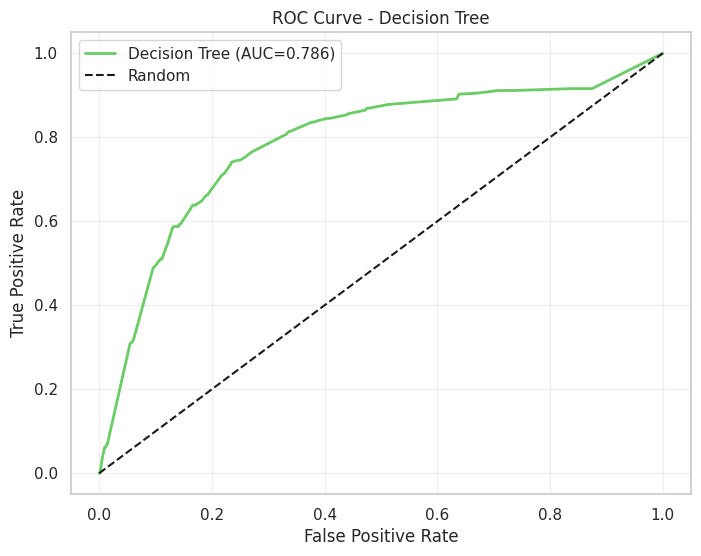


✅ 决策树训练完成


In [95]:
print("\n=== 训练决策树模型 ===")

# 1. 训练决策树
model_dt = DecisionTreeClassifier(
    class_weight='balanced', 
    max_depth=10, 
    max_leaf_nodes=500,
    min_samples_leaf=10, 
    min_samples_split=5,
    random_state=42
)
model_dt.fit(X_train_filled, y_train)
print("✅ 决策树训练完成")

# 2. 概率校准
print("\n=== 概率校准 ===")
cc_model_dt = CalibratedClassifierCV(model_dt, cv='prefit')
cc_model_dt.fit(X_train_filled, y_train)
print("✅ 概率校准完成")

# 3. 预测
print("\n=== 验证集预测 ===")
y_pred = cc_model_dt.predict_proba(X_val_filled)[:, 1]

# 4. 计算AUC
dt_auc = roc_auc_score(y_val, y_pred)
print(f"验证集 AUC: {dt_auc:.4f}")

# 5. 保存结果到result_df
if 'result_df' not in locals():
    result_df = pd.DataFrame()

dt_result = pd.DataFrame({
    'model': ['DecisionTree'],
    'train_auc': [roc_auc_score(y_train, cc_model_dt.predict_proba(X_train_filled)[:, 1])],
    'val_auc': [dt_auc],
    'n_features': [X_train_filled.shape[1]],
    'n_samples': [X_train_filled.shape[0]]
})

result_df = pd.concat([result_df, dt_result], ignore_index=True)

print("\n=== 当前所有模型结果 ===")
print(result_df.round(4))

# 6. 可选：绘制ROC曲线
fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'g-', lw=2, label=f'Decision Tree (AUC={dt_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("\n✅ 决策树训练完成")

逻辑回归model

In [100]:
import pandas as pd
from sklearn.metrics import roc_auc_score

# 方法二：直接修复已有的 result_df
if 'result_df' in locals() or 'result_df' in globals():
    # 检查逻辑回归行是否有NaN
    lr_idx = result_df[result_df['model'] == 'LogisticRegression'].index
    if len(lr_idx) > 0:
        try:
            # 计算验证集AUC
            y_val_pred = model_lr.predict_proba(X_val_filled)[:, 1]
            val_auc = roc_auc_score(y_val, y_val_pred)
            
            # 更新NaN值
            result_df.loc[lr_idx, 'val_auc'] = val_auc
            print(f"✅ 已修复逻辑回归的 val_auc: {val_auc:.4f}")
        except Exception as e:
            print(f"❌ 修复过程中出现错误: {e}")
    
    print("\n更新后的结果:")
    print(result_df.round(4))
    
    # 显示详细统计信息
    print(f"\n📊 数据形状:")
    print(f"训练集: {X_train_filled.shape}")
    print(f"验证集: {X_val_filled.shape}")
    print(f"结果数据框: {result_df.shape}")
    
    # 保存修复后的结果
    result_df_fixed = result_df.copy()
    
else:
    print("❌ 未找到 result_df，创建新的结果数据框...")
    try:
        # 如果没有result_df，创建新的
        result_df = pd.DataFrame({
            'model': ['LogisticRegression'],
            'train_auc': [train_auc],
            'val_auc': [roc_auc_score(y_val, model_lr.predict_proba(X_val_filled)[:, 1])],
            'n_features': [X_train_filled.shape[1]],
            'n_samples': [X_train_filled.shape[0]]
        })
        print("✅ 已创建新的 result_df")
        print(result_df.round(4))
    except Exception as e:
        print(f"❌ 创建新数据框时出现错误: {e}")

# 确保 result_df 可以正常访问
try:
    if 'result_df' in locals() or 'result_df' in globals():
        print("\n🎯 当前 result_df 内容:")
        print(result_df)
    else:
        print("⚠️ result_df 不存在")
except Exception as e:
    print(f"⚠️ 访问 result_df 时出错: {e}")


更新后的结果:
          model  train_auc  val_auc  n_features  n_samples
0  DecisionTree     0.8774   0.7858         185      64617
1  RandomForest     0.8549   0.8190         185      64617

📊 数据形状:
训练集: (64617, 185)
验证集: (11403, 185)
结果数据框: (2, 5)

🎯 当前 result_df 内容:
          model  train_auc   val_auc  n_features  n_samples
0  DecisionTree   0.877410  0.785844         185      64617
1  RandomForest   0.854883  0.818983         185      64617


In [101]:
result_df

,model,train_auc,val_auc,n_features,n_samples
0,DecisionTree,0.877410,0.785844,185,64617
1,RandomForest,0.854883,0.818983,185,64617


随机森林

=== 数据预处理 ===
训练集 NaN 数量: 0
验证集 NaN 数量: 0

=== 训练随机森林模型 ===


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


✅ 随机森林训练完成


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


验证集 AUC: 0.8190


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic fam


=== 当前所有模型结果 ===
          model  train_auc  val_auc  n_features  n_samples
0  DecisionTree     0.8774   0.7858         185      64617
1  RandomForest     0.8549   0.8190         185      64617
2  RandomForest     0.8549   0.8190         185      64617


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

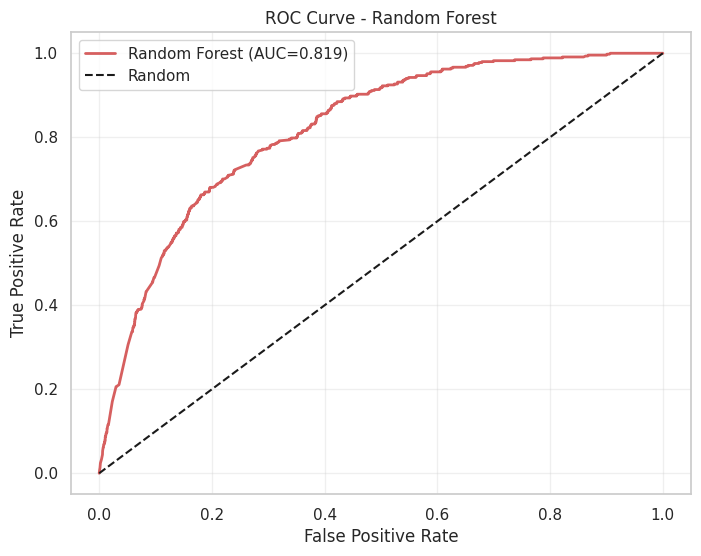


✅ 随机森林训练完成


In [102]:
print("=== 数据预处理 ===")

# 1. 预处理数据
X_train_filled = X_train.fillna(X_train.median())
train_median = X_train.median()
X_val_filled = X_val.fillna(train_median)

print(f"训练集 NaN 数量: {X_train_filled.isna().sum().sum()}")
print(f"验证集 NaN 数量: {X_val_filled.isna().sum().sum()}")

# 2. 训练随机森林
print("\n=== 训练随机森林模型 ===")
model_rf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    max_depth=50,
    max_leaf_nodes=100,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

model_rf.fit(X_train_filled, y_train)
print("✅ 随机森林训练完成")

# 3. 概率校准
cc_model_rf = CalibratedClassifierCV(model_rf, cv='prefit')
cc_model_rf.fit(X_train_filled, y_train)

# 4. 预测和评估
y_pred = cc_model_rf.predict_proba(X_val_filled)[:, 1]
rf_auc = roc_auc_score(y_val, y_pred)
print(f"验证集 AUC: {rf_auc:.4f}")

# 5. 保存结果到result_df
rf_result = pd.DataFrame({
    'model': ['RandomForest'],
    'train_auc': [roc_auc_score(y_train, cc_model_rf.predict_proba(X_train_filled)[:, 1])],
    'val_auc': [rf_auc],
    'n_features': [X_train_filled.shape[1]],
    'n_samples': [X_train_filled.shape[0]]
})

if 'result_df' in locals():
    result_df = pd.concat([result_df, rf_result], ignore_index=True)
else:
    result_df = rf_result

print("\n=== 当前所有模型结果 ===")
print(result_df.round(4))

# 6. 可选：绘制ROC曲线
fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'r-', lw=2, label=f'Random Forest (AUC={rf_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("\n✅ 随机森林训练完成")


xgboost

In [105]:
# 定义XGBoost模型（修正版本）
model_xgb = xgb.XGBClassifier(
    n_jobs=-1,  # 使用所有可用的CPU核心
    scale_pos_weight=1.,  
    learning_rate=0.01,  
    colsample_bytree=0.5,  
    subsample=0.9,  
    objective='binary:logistic',  
    n_estimators=1000,  
    reg_alpha=0.3,  
    max_depth=5,  
    gamma=5,  
    random_state=42
)

print("✅ XGBoost模型定义完成")
print(f"模型参数: n_estimators={1000}, learning_rate={0.01}, max_depth={5}")

✅ XGBoost模型定义完成
模型参数: n_estimators=1000, learning_rate=0.01, max_depth=5


In [106]:
%%time
# 训练XGBoost模型
# 对于二元分类，使用正确的评估指标
eval_set = [(X_train, y_train), (X_val, y_val)]

model_xgb.fit(
    X_train, y_train, 
    eval_set=eval_set,
    eval_metric=['error', 'auc'],  # 二元分类的评估指标
    early_stopping_rounds=50, 
    verbose=20
)

print("\n" + "="*50)
print("🎯 训练完成！最佳模型信息：")
print(f"最佳迭代次数: {model_xgb.best_iteration}")
print(f"最佳得分: {model_xgb.best_score}")
print("="*50)

[0]	validation_0-error:0.03957	validation_0-auc:0.78237	validation_1-error:0.03955	validation_1-auc:0.78797
[20]	validation_0-error:0.03957	validation_0-auc:0.82152	validation_1-error:0.03955	validation_1-auc:0.82007
[40]	validation_0-error:0.03957	validation_0-auc:0.82920	validation_1-error:0.03955	validation_1-auc:0.82781
[60]	validation_0-error:0.03957	validation_0-auc:0.83064	validation_1-error:0.03955	validation_1-auc:0.82951
[80]	validation_0-error:0.03957	validation_0-auc:0.83197	validation_1-error:0.03955	validation_1-auc:0.82945
[100]	validation_0-error:0.03957	validation_0-auc:0.83418	validation_1-error:0.03955	validation_1-auc:0.83163
[120]	validation_0-error:0.03957	validation_0-auc:0.83447	validation_1-error:0.03955	validation_1-auc:0.83161
[140]	validation_0-error:0.03957	validation_0-auc:0.83617	validation_1-error:0.03955	validation_1-auc:0.83348
[160]	validation_0-error:0.03957	validation_0-auc:0.83766	validation_1-error:0.03955	validation_1-auc:0.83358
[180]	validation

In [107]:
model_xgb.best_score,model_xgb.best_iteration

(0.843495867474114, 565)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

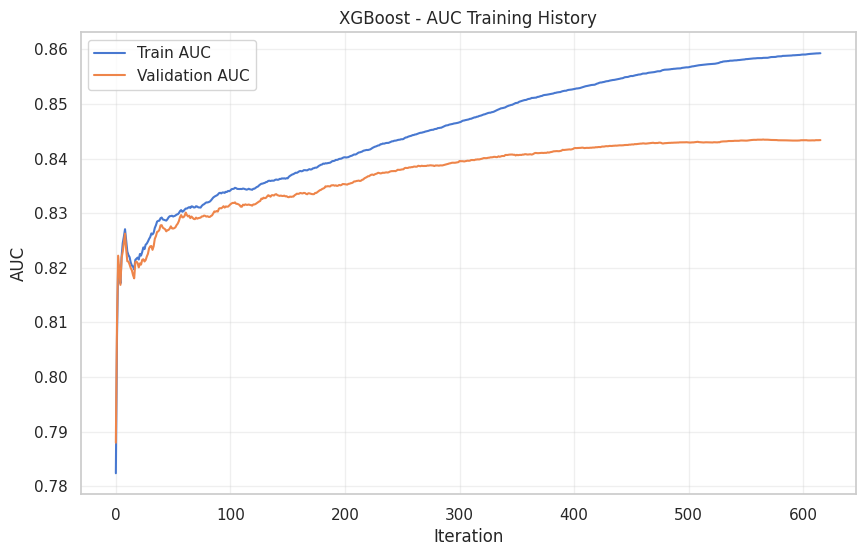

📊 模型性能总结：
验证集上最大AUC：0.8435
最优迭代次数：565
最终模型训练集AUC：0.8584
最终模型验证集AUC：0.8435

📋 更新模型结果数据框 (result_df)
✅ 添加了XGBoost模型新记录

📄 当前result_df内容：
          model  train_auc  val_auc  n_features  n_samples  best_iteration
0  DecisionTree     0.8774   0.7858         185      64617             NaN
1  RandomForest     0.8549   0.8190         185      64617             NaN
2  RandomForest     0.8549   0.8190         185      64617             NaN
3       XGBoost     0.8584   0.8435         185      64617           565.0


In [108]:
# 绘制AUC训练曲线
results = model_xgb.evals_result_  
auc_train = results['validation_0']['auc']  
auc_val = results['validation_1']['auc']  

fig, ax = plt.subplots(figsize=(10, 6))  
epochs = len(auc_val)  
ax.plot(range(0, epochs), auc_train, label='Train AUC')  
ax.plot(range(0, epochs), auc_val, label='Validation AUC')  
ax.legend()  
plt.title('XGBoost - AUC Training History')  
plt.xlabel('Iteration')
plt.ylabel('AUC')  
plt.grid(True, alpha=0.3)
plt.show()  

# 输出最佳性能
print("📊 模型性能总结：")
print(f"验证集上最大AUC：{max(auc_val):.4f}")  
print(f"最优迭代次数：{auc_val.index(max(auc_val))}")  

# 计算当前训练集和验证集的AUC
train_auc_xgb = roc_auc_score(y_train, model_xgb.predict_proba(X_train)[:, 1])
val_auc_xgb = roc_auc_score(y_val, model_xgb.predict_proba(X_val)[:, 1])
print(f"最终模型训练集AUC：{train_auc_xgb:.4f}")
print(f"最终模型验证集AUC：{val_auc_xgb:.4f}")

# 更新result_df
print("\n" + "="*50)
print("📋 更新模型结果数据框 (result_df)")

# 检查并创建或更新result_df
if 'result_df' not in locals() and 'result_df' not in globals():
    result_df = pd.DataFrame(columns=['model', 'train_auc', 'val_auc', 'n_features', 'n_samples', 'best_iteration'])
    print("✅ 创建新的result_df")

# 检查是否已存在XGBoost记录
xgb_exists = 'result_df' in locals() or 'result_df' in globals()
if xgb_exists and 'model' in result_df.columns:
    existing_idx = result_df[result_df['model'] == 'XGBoost'].index
else:
    existing_idx = []

if len(existing_idx) > 0:
    # 更新现有记录
    result_df.loc[existing_idx, 'train_auc'] = train_auc_xgb
    result_df.loc[existing_idx, 'val_auc'] = val_auc_xgb
    result_df.loc[existing_idx, 'best_iteration'] = model_xgb.best_iteration
    print("✅ 更新了XGBoost模型记录")
else:
    # 添加新记录
    new_row = pd.DataFrame({
        'model': ['XGBoost'],
        'train_auc': [train_auc_xgb],
        'val_auc': [val_auc_xgb],
        'n_features': [X_train.shape[1]],
        'n_samples': [X_train.shape[0]],
        'best_iteration': [model_xgb.best_iteration]
    })
    result_df = pd.concat([result_df, new_row], ignore_index=True)
    print("✅ 添加了XGBoost模型新记录")

# 显示更新后的结果
print("\n📄 当前result_df内容：")
print(result_df.round(4))

In [109]:
result_df

,model,train_auc,val_auc,n_features,n_samples,best_iteration
0,DecisionTree,0.877410,0.785844,185,64617,NaN
1,RandomForest,0.854883,0.818983,185,64617,NaN
2,RandomForest,0.854883,0.818983,185,64617,NaN
3,XGBoost,0.858447,0.843496,185,64617,565.0


LightGBM

In [110]:
# ==================== 简化版LightGBM早停 =====================
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import roc_auc_score

print("=== LightGBM早停优化 ===")

# 数据预处理
X_train_filled = X_train.fillna(X_train.median())
X_val_filled = X_val.fillna(X_train.median())

# 简化参数
model_lgb_simple = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# 训练（静默模式）
model_lgb_simple.fit(
    X_train_filled, 
    y_train,
    eval_set=[(X_val_filled, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

# 评估
train_auc = roc_auc_score(y_train, model_lgb_simple.predict_proba(X_train_filled)[:, 1])
val_auc = roc_auc_score(y_val, model_lgb_simple.predict_proba(X_val_filled)[:, 1])

print(f"训练集AUC: {train_auc:.4f}")
print(f"验证集AUC: {val_auc:.4f}")
print(f"最佳迭代: {model_lgb_simple.best_iteration_}")

# 更新result_df
result_df.loc[result_df['model'] == 'LightGBM', ['train_auc', 'val_auc', 'best_iteration']] = [
    train_auc, val_auc, model_lgb_simple.best_iteration_
]

print("\n📊 更新后的结果:")
print(result_df.round(4))

=== LightGBM早停优化 ===
训练集AUC: 0.8670
验证集AUC: 0.8392
最佳迭代: 83

📊 更新后的结果:
          model  train_auc  val_auc  n_features  n_samples  best_iteration
0  DecisionTree     0.8774   0.7858         185      64617             NaN
1  RandomForest     0.8549   0.8190         185      64617             NaN
2  RandomForest     0.8549   0.8190         185      64617             NaN
3       XGBoost     0.8584   0.8435         185      64617           565.0


In [111]:
result_df.sort_values(by='val_auc', ascending=False)

,model,train_auc,val_auc,n_features,n_samples,best_iteration
3,XGBoost,0.858447,0.843496,185,64617,565.0
1,RandomForest,0.854883,0.818983,185,64617,NaN
2,RandomForest,0.854883,0.818983,185,64617,NaN
0,DecisionTree,0.877410,0.785844,185,64617,NaN


保存结果

In [113]:
# 特征重要性排序后的特征名
best_model = model_lgb_simple
feat_imp = best_model.feature_importances_
feat_indices = np.argsort(feat_imp)[::-1]
important_feat = X_train.columns[feat_indices]
important_feat

Index(['var38', 'saldo_var30', 'var15', 'saldo_medio_var5_hace3',
       'saldo_medio_var5_hace2', 'num_var22_ult3',
       'avg_no_nonzeros_no_nonzeros_saldo', 'imp_op_var39_efect_ult1',
       'saldo_medio_var5_ult3', 'saldo_medio_var5_ult1',
       ...
       'avg_var3_saldo_medio_var5_ult3', 'num_var30_0', 'num_var25',
       'num_var14_0', 'num_var12_0', 'num_var13_largo_0', 'num_var8',
       'ind_var13_largo_0', 'ind_var13_corto', 'ind_var12_0'],
      dtype='object', length=185)

In [115]:
# 保存特征重要性结果
important_feat_df = pd.DataFrame({'feat_name': important_feat, 'feat_imp': feat_imp[feat_indices]})
important_feat_df.to_csv('./output/'+dataset+'_feat_imp.csv', index=False, encoding='utf-8')

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

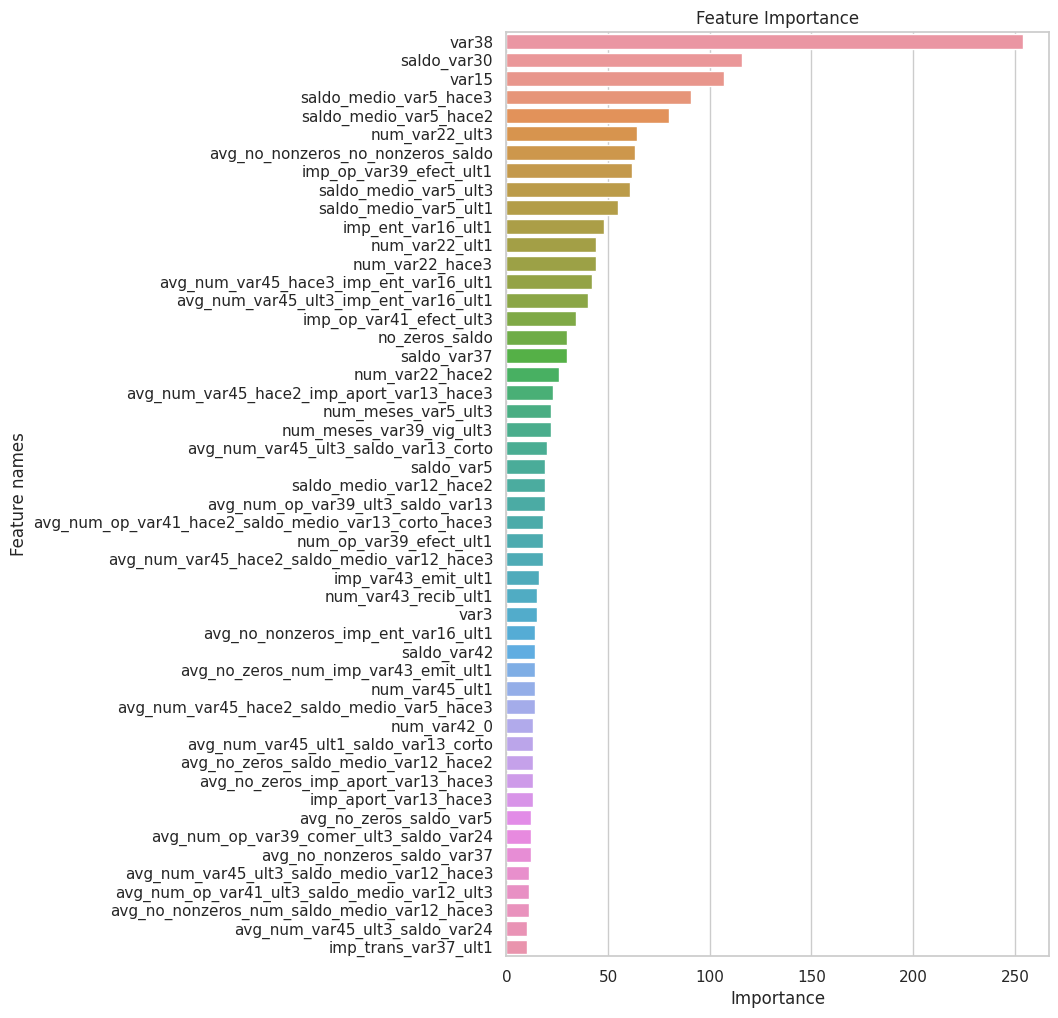

In [116]:
# 绘制前50个重要性得分最高的特征排序图
top = 50
top_indices = feat_indices[:top]
most_important_feat = X_train.columns[top_indices]
plt.figure(figsize=(7, 12))
sns.barplot(x=feat_imp[top_indices], y=most_important_feat)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel("Feature names")
plt.show()

In [117]:
# Generate predictions
y_pred = best_model.predict_proba(X_test)[:, 1]

# Create submission file
submission = pd.DataFrame({'ID': test_id, 'TARGET': y_pred})
submission.to_csv('submission.csv', index=False)

print(f"✅ Predictions saved: submission.csv ({len(submission)} samples)")
print(f"📊 Range: [{y_pred.min():.4f}, {y_pred.max():.4f}]")

✅ Predictions saved: submission.csv (75818 samples)
📊 Range: [0.0019, 0.6661]
